# kaggle kernel の解読

## 人のコードのコピー　(https://www.kaggle.com/danieleewww/avito-lightgbm-with-ridge-feature-v-2-0-e0760b/code)

In [1]:
#Initially forked from Bojan's kernel here: https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2242/code
#improvement using kernel from Nick Brook's kernel here: https://www.kaggle.com/nicapotato/bow-meta-text-and-dense-features-lgbm
#Used oof method from Faron's kernel here: https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867
#Used some text cleaning method from Muhammad Alfiansyah's kernel here: https://www.kaggle.com/muhammadalfiansyah/push-the-lgbm-v19
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

# Tf-Idf
#import nltk
#nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

NFOLDS = 5
SEED = 1234
VALID = False

/home/stanaya/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/stanaya/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
## scikit-learn classifierのラッパークラス
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

In [3]:
# OOF : Out Of Fold
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [4]:
def cleanName(text):
    try:
        textProc = text.lower()
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [5]:
print("\nData Load Stage")
training = pd.read_csv('/home/stanaya/.kaggle/competitions/avito-demand-prediction/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('/home/stanaya/.kaggle/competitions/avito-demand-prediction/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index

ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))


Data Load Stage
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns


In [6]:
# 学習データとテストデータを統合
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [7]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

Feature Engineering


In [8]:
#df.head()

In [9]:
#df2 = df.reset_index()

In [10]:
#df2["user_id"].drop_duplicates()

In [11]:
# 曜日、週の情報を追加
print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day


Create Time Variables


In [12]:
# Create Validation Index and Remove Dead Variables
# training と validation のindexを抽出(item_id)
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True) # imageの情報は使わない

# categoricalな特徴量を抽出する
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
# 文字データを離散数値に変換
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [13]:
#df.head()

In [14]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
# 句読点、括弧の数を特徴量にする
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# タイトルと説明文を正規化する
df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

# タイトルと説明文の全単語数とユニークな単語種類、さらにそれらの比を撮ったものを加える
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words


Text Features


In [ ]:
#df.head()

In [15]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
# ロシア語のストップワード（自然言語処理する際に一般的で役に立たない等の理由で処理対象外とする単語）の除去
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [16]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

In [17]:
#vectorizer 

In [18]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 10.28 Minutes


In [19]:
# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

In [20]:
#df.head()

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':20.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23045794310261566


In [22]:
print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

Modeling Stage


In [23]:
## Load LSI feature
df_lsi_feature = pd.read_csv('topic_feature_lsi.csv', index_col = "item_id")

In [25]:
df_lsi_feature.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
#df.head()

In [26]:
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]], csr_matrix(df_lsi_feature.loc[traindex,:].values)]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:], csr_matrix(df_lsi_feature.loc[testdex,:].values)])
tfvocab = df.columns.tolist() + tfvocab + df_lsi_feature.columns.tolist()
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df, df_lsi_feature
gc.collect();

1503424 Rows and 1430983 Cols
508438 Rows and 1430983 Cols
Feature Names Length:  1430983


In [27]:
print("\nModeling Stage")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=1234)

del ridge_preds,vectorizer,ready_df
gc.collect();


Modeling Stage


In [28]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 300,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.85,
    # 'bagging_freq': 5,
    'learning_rate': 0.019,
    'verbose': 0
}  


Light Gradient Boosting Regressor


In [29]:
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=1234)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=n_rounds,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=910,
        verbose_eval=100
    )

/home/stanaya/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


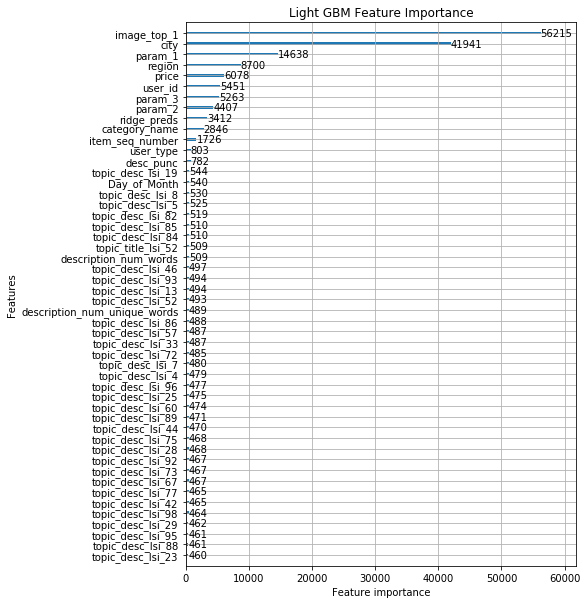

In [30]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

In [31]:
print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

Model Evaluation Stage


/home/stanaya/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [32]:
lgpred

array([0.23839891, 0.07375062, 0.17896392, ..., 0.03238921, 0.44549403,
       0.07169398])

In [33]:
#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub_lsi.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 138.57 Minutes
